# WhatsApp Group Analysis - IMS

#### This script can be used to analyze the WAG Performance within Customer Service Division

#### Metrics
1. Total Chat Count
2. Average Chat Count - **(On Process)**
3. Total Word Count - **(On Process)**
4. Average Response Lead Time - **(On Process)**
5. Most Active Days
6. Chat Trend (Season)
7. Chat Trend (Month)
8. Chat Trend (Week)
9. Chat Trend (Hour)
10. Date Correlation
11. Buzzword
12. Sentiment Analysis - **(On Process)**

### Importing Library 

To import the library needed for the analysis

In [234]:
import os
import re
import regex
import nltk
import pandas as pd
import numpy as np
import datetime as dt
from datetime import *
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from seaborn import *
from seaborn import heatmap
from nltk import *
from plotly import express as px
%matplotlib inline
from IPython import display

### Opening File

To load the file

In [235]:
conversationPath = 'IMS x TA.txt'             
with open(conversationPath, mode='r', encoding="utf8") as f:
    data = f.readlines()

### Cleaning Text Format

To clean the text format exported from WhatsApp

* *Check whether it is a new line or not*
* *If the following chars are in the line, assumed that it is not a new line*
* *There are 2 categories, text message and attached message*

In [236]:
dataset = data[1:]
cleaned_data = []
for line in dataset:
    
    if '/' in line and '.' in line and ':' in line and 'omitted' in line:
        date = line.split(" ")[0][2:]
        line2 = line[len(date):]
        time = line2.split("]")[0][3:]
        line3 = line2[len(time):]
        name = line3.split(":")[0][5:]
        line4 = line3[len(name):]
        message = line4[7:-1] 
        cleaned_data.append([date, time, name, message])

    elif '/' in line and '.' in line and ':' in line:
        date = line.split(" ")[0][1:]
        line2 = line[len(date):]
        time = line2.split("]")[0][2:]
        line3 = line2[len(time):]
        name = line3.split(":")[0][4:]
        line4 = line3[len(name):]
        message = line4[6:-1] 
        cleaned_data.append([date, time, name, message])

### Creating DataFrame

To convert the text file into dataframe

In [237]:
df = pd.DataFrame(cleaned_data, columns = ['Date', 'Time', 'Name', 'Message'])
df.drop(df[df['Name'] == ''].index, inplace = True)
df.columns

Index(['Date', 'Time', 'Name', 'Message'], dtype='object')

### Creating Member Flag

To create the column that consists of member's type


In [238]:
df['Name Category'] = np.where(df['Name'].str.contains("IMS", case=False, na=False), 'Client', 'TitipAja')
df['Name Category'].unique()

array(['TitipAja', 'Client'], dtype=object)

### Creating Division Flag

To create the column that consists of member's division 

In [239]:
df['Division Category'] = np.where(df['Name'].str.contains("CS", case=False, na=False), 'CS', np.where(df['Name'].str.contains("CX", case=False, na=False),'CX','Client'))
df['Division Category'].unique()

array(['Client', 'CS', 'CX'], dtype=object)

### Cleaning Date Column

To clean the date column

In [240]:
df['Date'] = pd.to_datetime(df['Date'], format ='%d/%m/%y', dayfirst=True)
df['Year'] = df['Date'].dt.year
df['Mon'] = df['Date'].dt.month
df['Day Number'] = df['Date'].dt.day

weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}

months = {
     1 : 'Jan',
     2 : 'Feb',
     3 : 'Mar',
     4 : 'Apr',
     5 : 'May',
     6 : 'Jun',
     7 : 'Jul',
     8 : 'Aug',
     9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'
}

df['Day'] = df['Date'].dt.weekday.map(weeks)
df['Month'] = df['Mon'].map(months)
df.drop('Mon',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5148 entries, 0 to 5167
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               5148 non-null   datetime64[ns]
 1   Time               5148 non-null   object        
 2   Name               5148 non-null   object        
 3   Message            5148 non-null   object        
 4   Name Category      5148 non-null   object        
 5   Division Category  5148 non-null   object        
 6   Year               5148 non-null   int64         
 7   Day Number         5148 non-null   int64         
 8   Day                5148 non-null   object        
 9   Month              5148 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 442.4+ KB


### Top 10 Member Chat Count

To know the total chat sent by each member

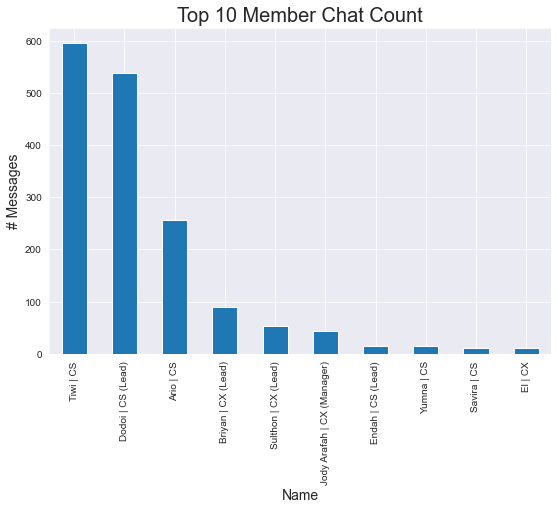

In [242]:
# CS Chat Count
plt.figure(figsize=(9,6))
cc_count = df[['Name','Name Category','Division Category']]
cc_count = cc_count[cc_count['Name Category'] == 'TitipAja']
cc_count = cc_count.loc[df['Name'].str.contains("CS|CX", case=False)]
cc_count = cc_count['Name'].value_counts()

# Top 10 CS 
m_a = cc_count.head(10)
m_a.plot.bar()
plt.xlabel('Name',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('# Messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Top 10 Member Chat Count',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

### Top 10 Most Active Days

To know the most active days

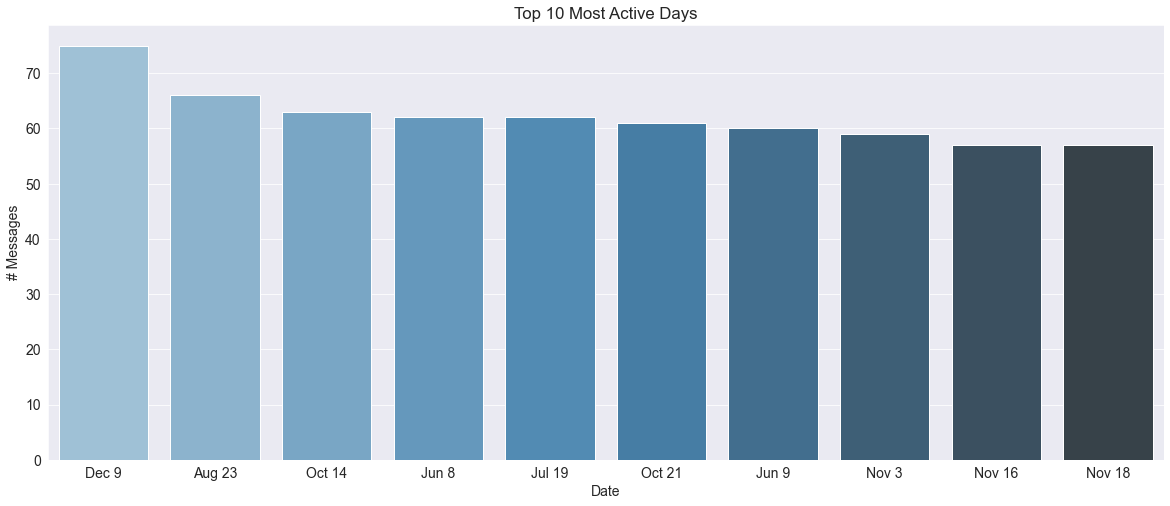

In [243]:
C_MAD = df.copy()
C_MAD['New Date'] = C_MAD['Month'].astype(str) + ' ' + C_MAD['Day Number'].astype(str) 
C_MAD['Chat_Count'] = [1] * C_MAD.shape[0] 
C_MAD = C_MAD.groupby('New Date').sum().reset_index()

MAD = C_MAD.sort_values(by='Chat_Count', ascending=False).head(10)
MAD.reset_index(inplace = True)
MAD.drop(columns="index", inplace=True)

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 8)

chart_MAD = sns.barplot(x="New Date", y="Chat_Count", data=MAD,
                 palette="Blues_d") 

chart_MAD.set(title='Top 10 Most Active Days',xlabel='Date',ylabel='# Messages');

### Chat Trend (All Time)

To seek the seasonal trendline

In [255]:
z = df.copy()
z = z['Date'].value_counts() 
z1 = z.to_dict() 
df['Msg_count'] = df['Date'].map(z1)

fig = px.line(x=df['Date'],y=df['Msg_count'])
fig.update_layout(title='Chat Trend (Season)',
                  xaxis_title='Date',
                  yaxis_title='# Messages')
fig.update_xaxes(nticks=20)
fig.show()

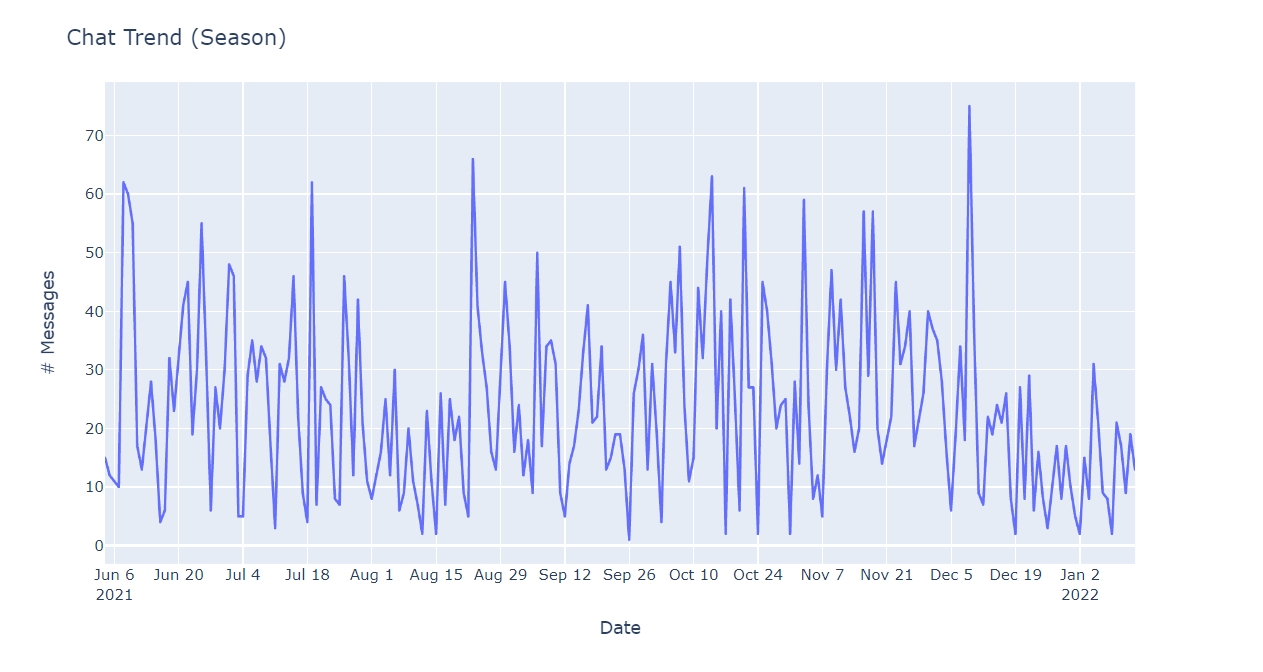

### Chat Trend (Month)

To seek the monthly trendline

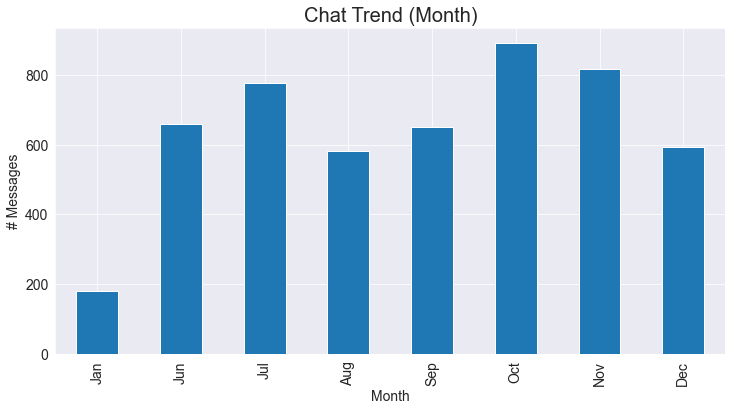

In [245]:
plt.figure(figsize=(12,6))
active_month = df['Month'].value_counts()
a_m = active_month
a_m.index = pd.CategoricalIndex(a_m.index, 
                               categories=[
                                   'Jan', 
                                   'Feb', 
                                   'Mar', 
                                   'Apr',
                                   'May',
                                   'Jun', 
                                   'Jul', 
                                   'Aug',
                                   'Sep', 
                                   'Oct', 
                                   'Nov', 
                                   'Dec'])
a_m = a_m.sort_index()
a_m.plot.bar()
plt.xlabel('Month',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('# Messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Chat Trend (Month)',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

### Chat Trend (Week)
To seek the weekly trendline

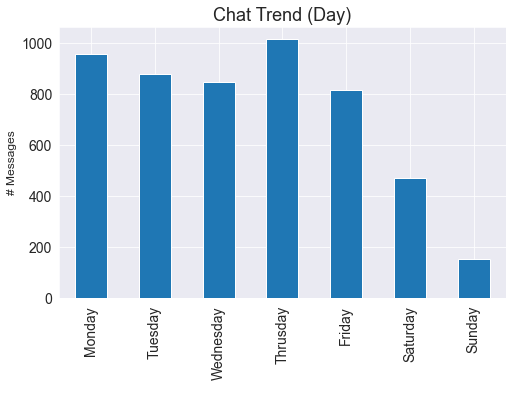

In [246]:
plt.figure(figsize=(8,5))
active_day = df['Day'].value_counts()
a_d = active_day.head(10)


a_d.index = pd.CategoricalIndex(a_d.index, 
                               categories=[
                                   'Monday', 
                                   'Tuesday', 
                                   'Wednesday', 
                                   'Thrusday',
                                   'Friday',
                                   'Saturday', 
                                   'Sunday'])
a_d = a_d.sort_index()

a_d.plot.bar()
plt.xlabel(' ',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('# Messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Chat Trend (Day)',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

### Chat Trend (Time)

To seek the hourly trendline

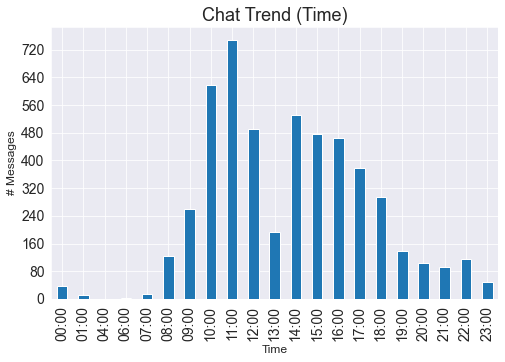

In [247]:
# Chat Trend (Time)
plt.figure(figsize=(8,5))

df['Time Range'] = pd.to_datetime(df['Time'], format='%H.%M.%S').dt.ceil(freq='H')
df['Time Range'] = df['Time Range'].dt.strftime('%H').add(':00')
t = df['Time Range'].value_counts()
t.index = pd.CategoricalIndex(t.index, 
                               categories=[
                                   '00:00', 
                                   '01:00', 
                                   '02:00', 
                                   '03:00',
                                   '04:00',
                                   '05:00', 
                                   '06:00', 
                                   '07:00',
                                   '08:00', 
                                   '09:00', 
                                   '10:00', 
                                   '11:00',
                                   '12:00', 
                                   '13:00', 
                                   '14:00', 
                                   '15:00',
                                   '16:00',
                                   '17:00', 
                                   '18:00', 
                                   '19:00',
                                   '20:00', 
                                   '21:00', 
                                   '22:00',
                                   '23:00', 
                                   '24:00'])
t = t.sort_index()
tx = t.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True))  #Converting y axis data to integer
plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('# Messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Chat Trend (Time)',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

### Date Corrrelation

To seek correlation between month and day

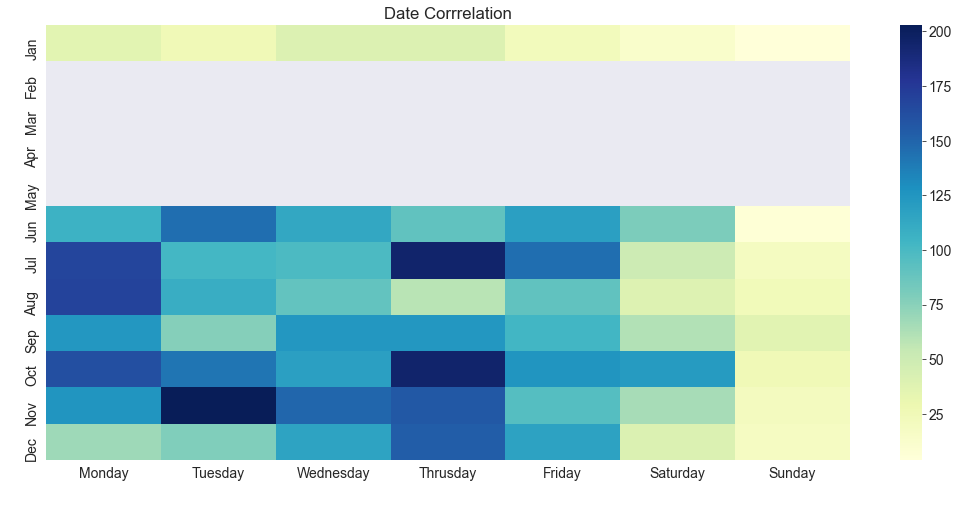

In [249]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 8)

sns.set_style("darkgrid")

DC = df.copy()
DC['Chat_Count'] = [1] * DC.shape[0] 
grouped_by_month_and_day = DC.groupby(['Month', 'Day']).sum().reset_index()[['Month', 'Day', 'Chat_Count']]

months_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
weeks_order = ['Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday','Sunday']

pt = grouped_by_month_and_day.pivot_table(index = 'Month', columns = 'Day', values = 'Chat_Count').reindex(index = months_order, columns = weeks_order)

h_pt = sns.heatmap(pt, cmap = 'YlGnBu');
h_pt.set(title='Date Corrrelation',xlabel=' ',ylabel=' ');

### Opening Stopword List

To remove all nebulous words 

*adding more words to the list could make the analysis more accurate*

In [241]:
def load_words_from_file(path_to_file):
    sw_list = []
    with open(path_to_file, 'r') as f:
        [sw_list.append(word) for line in f for word in line.split()]
        return sw_list

excludedword = load_words_from_file('excludedword.txt')

### Detecting & Displaying Buzzword

To know the most popular buzzword used within the group chat

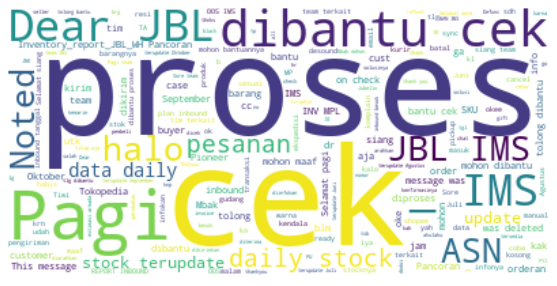

In [250]:
text = " ".join(review for review in df.Message)
wordcloud = WordCloud(stopwords=excludedword, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()